In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import tensorflow as tf
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import CosineSimilarity
from tensorflow.linalg import norm
from tensorflow import reduce_sum

from gw_grb_correlation.Fermi.data_preprocessing import create_dataframe_and_name_column_from_data_files

In [2]:
from gw_grb_correlation.Fermi.util import process_data

# Load data
fermi_data = create_dataframe_and_name_column_from_data_files(data_type='fermi')

# List of detectors
detectors = [f"n{i}" for i in range(10)] + ["na", "nb", "b0", "b1"]

# Define input columns
PH_CNT_columns = [f"{detector}_PH_CNT" for detector in detectors]
TRIG_columns = [f"{detector}_TRIG" for detector in detectors]
Orientation_columns = ['QSJ_1', 'QSJ_2', 'QSJ_3', 'QSJ_4']
fermi_data[PH_CNT_columns] = np.array(fermi_data[PH_CNT_columns].values.astype(np.float64)) * np.array(fermi_data[TRIG_columns].values.astype(np.float64))

input_columns = Orientation_columns + TRIG_columns + PH_CNT_columns

X_scaled, X_train_scaled, X_test_scaled, y, y_train, y_test = process_data(fermi_data, input_columns)

In [3]:
from gw_grb_correlation.Fermi.util import cosine_similarity_loss
# Define model with Dropout
model = Sequential([
    Dense(128, input_dim=X_train_scaled.shape[1], activation='relu'),
    Dropout(0.3),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(3, activation=None),  # Output layer, no activation
])

# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss=cosine_similarity_loss,
    metrics=[CosineSimilarity(name='cosine_similarity')]
)

c:\Program Files\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/400
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - cosine_similarity: 0.0446 - loss: -0.0446 - val_cosine_similarity: 0.0116 - val_loss: -0.0116
Epoch 2/400
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - cosine_similarity: 0.0286 - loss: -0.0286 - val_cosine_similarity: 0.0182 - val_loss: -0.0182
Epoch 3/400
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - cosine_similarity: 0.0801 - loss: -0.0801 - val_cosine_similarity: 0.0394 - val_loss: -0.0394
Epoch 4/400
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - cosine_similarity: 0.1126 - loss: -0.1126 - val_cosine_similarity: 0.0661 - val_loss: -0.0661
Epoch 5/400
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - cosine_similarity: 0.1291 - loss: -0.1291 - val_cosine_similarity: 0.0867 - val_loss: -0.0867
Epoch 6/400
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - cosine_similarity: 0.1317 - loss: -0.1317 - val_cosine_similarity: 0.1073 - val_loss: -0.1073
Epoch 7/400
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - cosine_similarity: 0.1321 - loss: -0.1321 - val_cos

Model trained and saved as model_with_orientation.h5
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - cosine_similarity: 0.9090 - loss: -0.9090 
Test Loss: -0.9094
Cosine Similarity: 0.9094
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Mean norm of predicted vectors: 0.55531824
Standard deviation of norms: 0.16676368


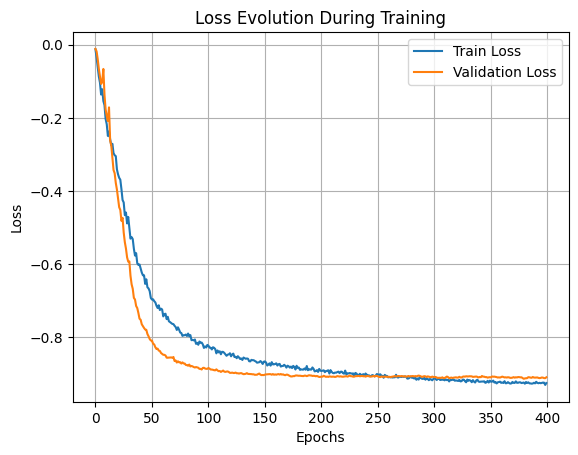

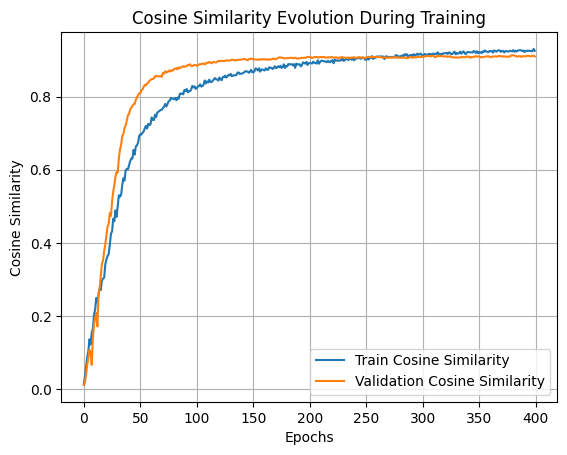

In [5]:
# Train model
history = model.fit(
    X_train_scaled, y_train,
    epochs=400,
    batch_size=16,
    validation_data=(X_test_scaled, y_test)
)

model_path = "model_with_orientation.h5"
# Save the trained model
model.save(model_path)
print(f"Model trained and saved as {model_path}")

from gw_grb_correlation.Fermi.visualization import evaluate_model_and_plot_accurracy
evaluate_model_and_plot_accurracy(model, history, X_test_scaled, y_test)

In [6]:
from gw_grb_correlation.Fermi.util import convert_cartesian_to_spherical
predictions = model.predict(X_scaled)

RA_DEC_predictions = np.array([convert_cartesian_to_spherical(pred) for pred in predictions])
fermi_predict_data = fermi_data.copy()

fermi_predict_data['RA'] = RA_DEC_predictions[:, 0]
fermi_predict_data['DEC'] = RA_DEC_predictions[:, 1]

fermi_predict_data.to_csv("fermi_predict_data.csv", index=False)


70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [7]:
from gw_grb_correlation.Fermi.util import filtering, duration
# Filter out short GRB data
short_GRB_data = filtering(fermi_predict_data, criteria={'T90': lambda x: x <= 2.1})

# Calculate the duration (difference between max TSTOP and min TSTART) and count the short GRB event number
duration_short_GRB = duration(short_GRB_data)
event_num_short_GRB = len(short_GRB_data)

# Calculate the average occurrence rate (events per unit of time)
average_occurrence_rate = event_num_short_GRB / duration_short_GRB

# Print the results
print(f"Number of events: {event_num_short_GRB}")
print(f"Total duration: {duration_short_GRB} seconds")
print(f"Average occurrence rate: {average_occurrence_rate} events per second")

Number of events: 357
Total duration: 323245732.96269 seconds
Average occurrence rate: 1.1044229315200459e-06 events per second


In [8]:
from gw_grb_correlation.Fermi.util import read_GW_data, remove_duplicate_times_in_gw_data, compare_time_within_range
# Load GW data
gw_data = read_GW_data(f"./gw_data/totalgwdata.csv")
gw_times = remove_duplicate_times_in_gw_data(gw_data)

# Find matched GRB-GW event pairs
match = compare_time_within_range(short_GRB_data, gw_times, time_range_seconds=86400*3)
filtered_gw_events = gw_data[gw_data['times'].isin(match['gw_time'])]
match.to_csv("GRB_predict_GW_event_pairs.csv", index=False)
filtered_gw_events.to_csv("Filtered_GW_events_with_GRB_prediction.csv", index=False)

Data from ./gw_data/totalgwdata.csv loaded successfully.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2418227 entries, 0 to 2418226
Data columns (total 5 columns):
 #   Column      Dtype  
---  ------      -----  
 0   Unnamed: 0  int64  
 1   ra          float64
 2   dec         float64
 3   times       float64
 4   weights     float64
dtypes: float64(4), int64(1)
memory usage: 92.2 MB
None
   Unnamed: 0        ra       dec         times   weights
0           0  1.891867 -1.250744  1.126259e+09  0.000024
1           1  1.254342 -1.228042  1.126259e+09  0.000024
2           2  1.666787 -1.279668  1.126259e+09  0.000024
3           3  1.863250 -1.261367  1.126259e+09  0.000024
4           4  0.994238 -1.036272  1.126259e+09  0.000024
Number of unique times after applying threshold: 91
First few unique times:
               times                          date
0       1.126259e+09 2015-09-14 09:51:02.000000000
44173   1.128679e+09 2015-10-12 09:55:00.000000000
79620   1.135136e+09 20

C:\Users\aw106\Desktop\theorywork\group_project_2025\gw_grb_correlation\Fermi\util.py:219: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fermi_data['ALIGNED_SEC'] = pd.to_numeric(fermi_data['TSTART'], errors='coerce')
C:\Users\aw106\Desktop\theorywork\group_project_2025\gw_grb_correlation\Fermi\util.py:225: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fermi_data['ALIGNED_SEC'] = fermi_data['ALIGNED_SEC'] + (fermi_start_date - pd.Timestamp("1980-01-01")).total_seconds()


Found 44 matches within 259200 seconds.


In [9]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,003,403 (3.83 MB)

 Trainable params: 334,467 (1.28 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 668,936 (2.55 MB)

In [11]:
# This time, we test model trained without spacecraft orientation data
# Load data again
fermi_data = create_dataframe_and_name_column_from_data_files(data_type='fermi')
input_columns = TRIG_columns + PH_CNT_columns # No Spacecraft Orientation

X_scaled, X_train_scaled, X_test_scaled, y, y_train, y_test = process_data(fermi_data, input_columns)

In [12]:
# Define model with Dropout
model_without_orientation = Sequential([
    Dense(128, input_dim=X_train_scaled.shape[1], activation='relu'),
    Dropout(0.3),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(3, activation=None),  # Output layer, no activation
])

# Compile model
model_without_orientation.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss=cosine_similarity_loss,
    metrics=[CosineSimilarity(name='cosine_similarity')]
)

c:\Program Files\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/400
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - cosine_similarity: -0.0152 - loss: 0.0152 - val_cosine_similarity: 0.0026 - val_loss: -0.0026
Epoch 2/400
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - cosine_similarity: 0.0214 - loss: -0.0214 - val_cosine_similarity: -0.0265 - val_loss: 0.0265
Epoch 3/400
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - cosine_similarity: -0.0066 - loss: 0.0066 - val_cosine_similarity: 7.4461e-04 - val_loss: -7.4461e-04
Epoch 4/400
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - cosine_similarity: 0.0336 - loss: -0.0336 - val_cosine_similarity: 0.0193 - val_loss: -0.0193
Epoch 5/400
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - cosine_similarity: 0.0517 - loss: -0.0517 - val_cosine_similarity: 0.0320 - val_loss: -0.0320
Epoch 6/400
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - cosine_similarity: 0.0528 - loss: -0.0528 - val_cosine_similarity: 0.0283 - val_loss: -0.0283
Epoch 7/400
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - cosine_similarity: 0.0574 - loss: -0.0574 -

Model trained and saved as model_without_orientation.h5
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - cosine_similarity: 0.2016 - loss: -0.2016 
Test Loss: -0.1888
Cosine Similarity: 0.1888
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Mean norm of predicted vectors: 0.18321721
Standard deviation of norms: 0.78456414


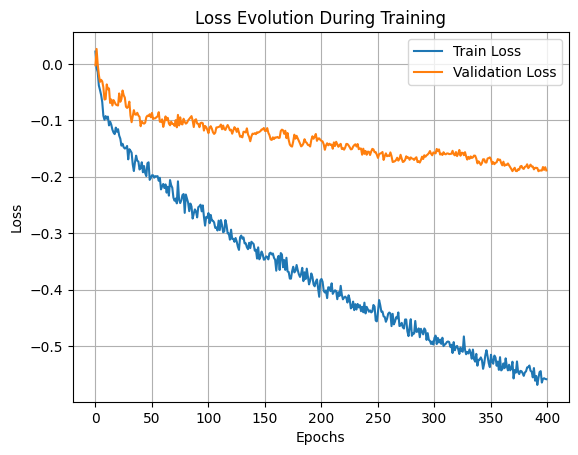

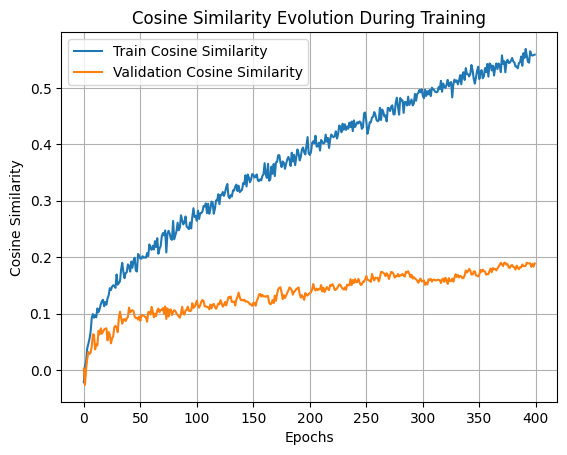

In [13]:
# Train model
history_without_orientation = model_without_orientation.fit(
    X_train_scaled, y_train,
    epochs=400,
    batch_size=16,
    validation_data=(X_test_scaled, y_test)
)
model_without_orientation_path = "model_without_orientation.h5"
# Save the trained model
model_without_orientation.save(model_without_orientation_path)
print(f"Model trained and saved as {model_without_orientation_path}")

evaluate_model_and_plot_accurracy(model_without_orientation, history_without_orientation, X_test_scaled, y_test)

In [14]:
model_without_orientation.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 128)            │         3,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,001,867 (3.82 MB)

 Trainable params: 333,955 (1.27 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 667,912 (2.55 MB)